In [1]:
# imports
import os, sys

# third party imports
import numpy as np
import tqdm
import pandas as pd
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

2023-11-06 14:48:14.713955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 14:48:15.644189: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/saumya/.conda/envs/tf/lib/:/home/saumya/.conda/envs/tf/lib/:/home/saumya/.conda/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-11-06 14:48:15.644343: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBR

In [2]:
model_loc = 'Models/'
csv_loc = 'CSV/'

In [3]:

## As per the tensorflow error #60309, advice by tgoMota on github, making verbose = 2

verbose = 2

In [4]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [5]:
def vxm_data_generator_real(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        yield (inputs, outputs)

In [6]:
# Conform test data.
def conform(x, in_shape = (256,) * 2):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))

2023-11-06 14:48:16.949353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 14:48:16.987240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 14:48:16.987463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 14:48:16.987896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

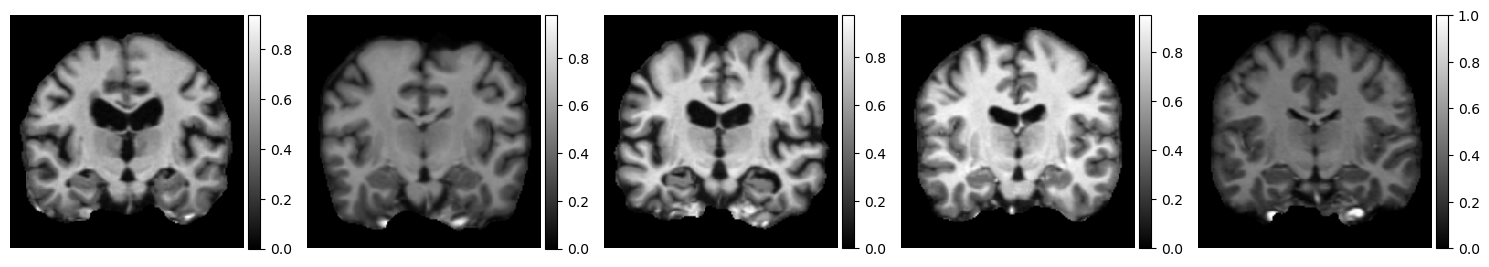

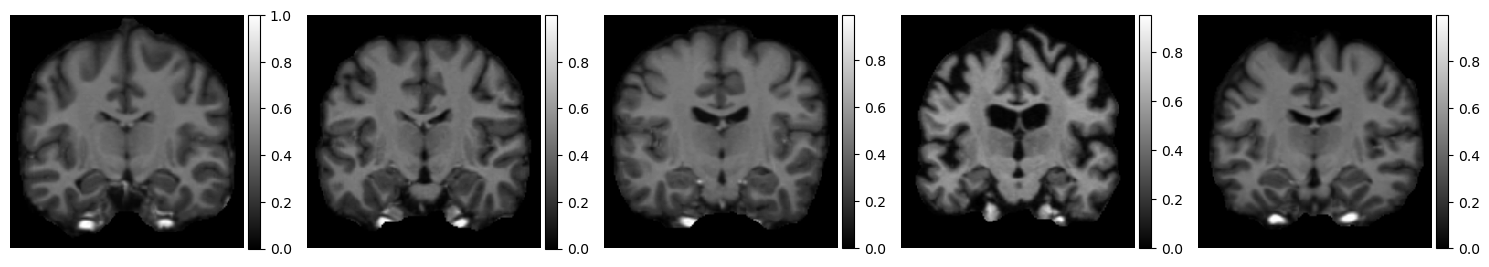

In [7]:
#Loading the dataset
images = ne.py.data.load_dataset('2D-OASIS-TUTORIAL')
conformed_images = [conform(img) for img in images]
#label_maps_real = [(img*15).astype('int').reshape(256, 256) for img in conformed_images]
label_maps_real = [img.reshape(256, 256) for img in conformed_images]


# Visualizing the dataset.
num_row = 2
per_row = 5
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps_real[i:i + per_row], cmaps=['gray'], do_colorbars=True)

In [16]:
class VxmTest():
    def __init__(self, ndim = 2, unet_input_features = 2):
        self.ndim = ndim
        self.unet_input_features = unet_input_features
    #CNN model
        # configure unet input shape (concatenation of moving and fixed images)
        self.vol_shape = real_train.shape[1:]
        # configure unet features 
        self.nb_features = [
            [32, 32, 32, 32],         # encoder features
            [32, 32, 32, 32, 32, 16]  # decoder features
        ]
        self.vxm_model = vxm.networks.VxmDense(self.vol_shape, nb_unet_features=None, int_steps=0)
        self.losses = ['mse', vxm.losses.Grad('l2').loss]
        self.loss_weights = [1, 0.01]
        self.vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=self.losses, loss_weights=self.loss_weights)
        
    
    def CNNvxm(self, train_gen=None, val_generator=None):
        self.train_generator = train_gen
        self.val_generator = val_generator

        self.in_sample, self.out_sample = next(self.train_generator)
        def Visual():
            # visualize
            images = [img[0, :, :, 0] for img in self.in_sample + self.out_sample]
            titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
            ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
        Visual()
        
    def train(self, total_epo, steps_per_epoch=100):

        # self.cp_callback = ModelCheckpoint(filepath=path, save_weights_only=False, verbose=1)
        # self.callbacks=[cp_callback]
        self.hist = self.vxm_model.fit(self.train_generator, epochs=total_epo,
                                       steps_per_epoch=100, verbose=verbose,
                                       callbacks=[TqdmCallback(verbose=verbose)],
                                       validation_data=self.val_generator,
                                       validation_steps = 100);
        plot_history(self.hist)
        
    def test(self, test_gen, loc, verbose=2, steps=1000):
        self.vxm_model.load_weights(loc)
        self.vxm_model.evaluate(test_gen, verbose=verbose,steps=steps)
    
    def RegPred(self, val_input):
        self.val_pred = self.vxm_model.predict(val_input)
        #visualise
        def Visual():
            images = [img[0, :, :, 0] for img in val_input + self.val_pred] 
            titles = ['moving', 'fixed', 'moved', 'flow']
            ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);
        Visual()
        return self.val_pred

In [17]:
#Fixing data + spliting

#conversion of labels in range of [0,1]
label_maps_real = np.array(label_maps_real)
# label_maps_synth = np.array(label_maps_synth)
#label_maps_real = label_maps_real.astype('float')/15
#label_maps_synth = label_maps_synth.astype('float')/15
#label_maps_hy = np.zeros((250, 256, 256))
#label_maps_hy[::2] = [i for i in label_maps_real[:125, ...]]
#label_maps_hy[1::2] = [i for i in label_maps_synth[:125, ...]]
#label_maps_hy = np.array(label_maps_hy)

#data split 
Data_split_train = 250
real_train = label_maps_real[:250, ...]
# few_shot_train = label_maps_real[:50, ...]
test_val_no = 82
real_val = label_maps_real[250:332, ...]
real_test = label_maps_real[-82:, ...]

In [18]:
batch_size = 16

In [19]:
test_generator = vxm_data_generator_real(real_test, batch_size = batch_size)
test_input, _ = next(test_generator)

In [20]:
loc = model_loc +'Synth_pure.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 76s - loss: 0.0104 - vxm_dense_transformer_loss: 0.0077 - vxm_dense_flow_loss: 0.2646 - 76s/epoch - 76ms/step


In [21]:
loc = model_loc +'Real_100steps.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 79s - loss: 0.0086 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 0.2034 - 79s/epoch - 79ms/step


In [22]:
loc = model_loc +'Fshot_5.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 77s - loss: 0.0102 - vxm_dense_transformer_loss: 0.0079 - vxm_dense_flow_loss: 0.2384 - 77s/epoch - 77ms/step


In [23]:
loc = model_loc +'Fshot_10.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 81s - loss: 0.0093 - vxm_dense_transformer_loss: 0.0071 - vxm_dense_flow_loss: 0.2232 - 81s/epoch - 81ms/step


In [38]:
model_loc_new = '/home/saumya/Documents/HybridMorph/HybridMorph_Data_test/30092023/Models/'

In [32]:
model_loc = '/home/saumya/Documents/HybridMorph/HybridMorph_Data_test/29092023/HPC/Models/'

In [33]:
loc = model_loc +'Hybr_0.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 77s - loss: 0.0102 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 0.2721 - 77s/epoch - 77ms/step


In [34]:
loc = model_loc +'Hybr_5.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 81s - loss: 0.0103 - vxm_dense_transformer_loss: 0.0075 - vxm_dense_flow_loss: 0.2816 - 81s/epoch - 81ms/step


In [35]:
loc = model_loc +'Hybr_10.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 79s - loss: 0.0100 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 0.2544 - 79s/epoch - 79ms/step


In [39]:
loc = model_loc_new +'Hybr_20.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 78s - loss: 0.0099 - vxm_dense_transformer_loss: 0.0073 - vxm_dense_flow_loss: 0.2569 - 78s/epoch - 78ms/step


In [40]:
loc = model_loc_new +'Hybr_30.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 80s - loss: 0.0099 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 0.2467 - 80s/epoch - 80ms/step


In [41]:
loc = model_loc_new +'Hybr_40.h5'

Synth = VxmTest()
Synth.test(test_generator, loc)

1000/1000 - 79s - loss: 0.0093 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 0.2467 - 79s/epoch - 79ms/step
